In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import seaborn as sns

# Load the dataset
data = pd.read_csv('solar_weather.csv', parse_dates=['Time'], index_col='Time')

# Display the first few rows
print(data.head())

# Check for missing values
print(data.isnull().sum())

# Fill missing values if necessary
data.fillna(method='ffill', inplace=True)  # Forward fill for simplicity


                     Energy delta[Wh]  GHI  temp  pressure  humidity  \
Time                                                                   
2017-01-01 00:00:00                 0  0.0   1.6      1021       100   
2017-01-01 00:15:00                 0  0.0   1.6      1021       100   
2017-01-01 00:30:00                 0  0.0   1.6      1021       100   
2017-01-01 00:45:00                 0  0.0   1.6      1021       100   
2017-01-01 01:00:00                 0  0.0   1.7      1020       100   

                     wind_speed  rain_1h  snow_1h  clouds_all  isSun  \
Time                                                                   
2017-01-01 00:00:00         4.9      0.0      0.0         100      0   
2017-01-01 00:15:00         4.9      0.0      0.0         100      0   
2017-01-01 00:30:00         4.9      0.0      0.0         100      0   
2017-01-01 00:45:00         4.9      0.0      0.0         100      0   
2017-01-01 01:00:00         5.2      0.0      0.0         100  

C:\Users\james\AppData\Local\Temp\ipykernel_14868\3599448593.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # Forward fill for simplicity


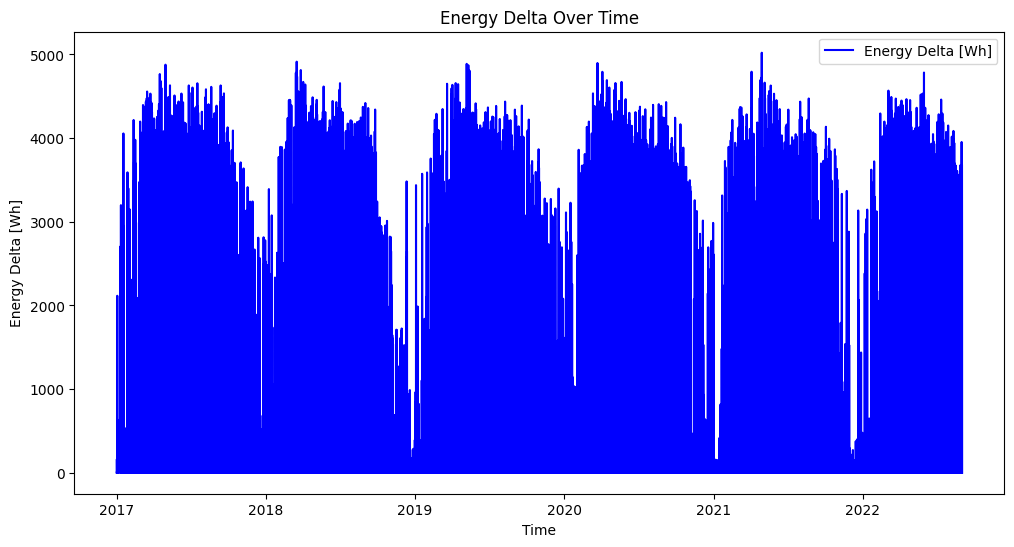

In [5]:
# Plot the Energy Delta over time
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Energy delta[Wh]'], label='Energy Delta [Wh]', color='blue')
plt.title('Energy Delta Over Time')
plt.xlabel('Time')
plt.ylabel('Energy Delta [Wh]')
plt.legend()
plt.show()


In [6]:
# Checking stationarity
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Energy delta[Wh]'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Autocorrelation and Partial Autocorrelation Plots
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sm.graphics.tsa.plot_acf(data['Energy delta[Wh]'], lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(data['Energy delta[Wh]'], lags=30, ax=ax[1])
plt.show()

# Fit SARIMAX model
# Define the order (p, d, q) and seasonal_order (P, D, Q, s) for SARIMAX
# These values should be selected based on ACF/PACF plots and experimentation
p = 1  # Autoregressive order
d = 1  # Integrated order
q = 1  # Moving average order
P = 1  # Seasonal autoregressive order
D = 1  # Seasonal differencing order
Q = 1  # Seasonal moving average order
s = 12  # Seasonal period (monthly data)

# Fitting the SARIMAX model
model = SARIMAX(data['Energy delta[Wh]'], order=(p, d, q), seasonal_order=(P, D, Q, s))
sarimax_fit = model.fit('6M')

# Summary of the model
print(sarimax_fit.summary())


In [ ]:
# Forecast the next n periods (e.g., 12 months)
n_forecast = 12
forecast = sarimax_fit.get_forecast(steps=n_forecast)
forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=n_forecast, freq='M')

# Create a DataFrame for the forecasted values
forecast_df = pd.DataFrame(forecast.predicted_mean, index=forecast_index, columns=['Forecasted Energy Delta [Wh]'])

# Plot actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Energy delta[Wh]'], label='Actual Energy Delta [Wh]', color='blue')
plt.plot(forecast_df.index, forecast_df['Forecasted Energy Delta [Wh]'], label='Forecasted Energy Delta [Wh]', color='orange')
plt.title('Energy Delta Forecast')
plt.xlabel('Time')
plt.ylabel('Energy Delta [Wh]')
plt.axvline(x=data.index[-1], color='red', linestyle='--', label='Forecast Start')
plt.legend()
plt.show()


In [ ]:
# Backtesting on the training set to evaluate model performance
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

# Fit the model on the training set
model = SARIMAX(train_data['Energy delta[Wh]'], order=(p, d, q), seasonal_order=(P, D, Q, s))
sarimax_fit = model.fit(disp=False)

# Predict on the test set
predictions = sarimax_fit.get_prediction(start=test_data.index[0], end=test_data.index[-1], dynamic=False)
predicted_mean = predictions.predicted_mean

# Calculate MSE
mse = mean_squared_error(test_data['Energy delta[Wh]'], predicted_mean)
print(f'Mean Squared Error: {mse}')

# Plot actual vs predicted on the test set
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['Energy delta[Wh]'], label='Actual Energy Delta [Wh]', color='blue')
plt.plot(predicted_mean.index, predicted_mean, label='Predicted Energy Delta [Wh]', color='orange')
plt.title('Actual vs Predicted Energy Delta')
plt.xlabel('Time')
plt.ylabel('Energy Delta [Wh]')
plt.legend()
plt.show()
